# Setup

In [1]:
import contextily as cx
import figure_utilities
import statsmodels.api as sm
import constants
from stats_utilities import produce_summary_statistics, test_balance
import geopandas as gpd
import matplotlib.pyplot as plt
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
import numpy as np
plt.rcParams['savefig.dpi'] = 300
import os
import pandas as pd

/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74154/395358981.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS

In [2]:
# Store paths.
INPUT_DATA_PANEL = "../data/03_cleaned/crime_analysis_monthly.csv"
INPUT_DATA_TRACTS = "../data/02_intermediate/tracts.csv"
INPUT_DATA_BOSTON_TRACTS_SHAPEFILE = "../data/01_raw/Census_2010_Tracts"
INPUT_DATA_OFFENSE_CODES = "../data/01_raw/rmsoffensecodes.xlsx"
OUTPUT_TABLES = "../output/final_paper/tables"
OUTPUT_FIGURES = "../output/final_paper/figures"
OUTPUT_STATISTICS = "../output/final_paper/summary_statistics_numbers_to_cite.tex"

# Summary Statistics

## Map of Evictions, Colored by Poverty Rate in Census Tract

In [3]:
# Read unrestricted dataset into memory.
df = pd.read_csv(INPUT_DATA_PANEL)
df = df.reset_index() # So we can use 'case_number' like a column

# Create spatial data 
unrestricted_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color='black',
                      markersize=0.05)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.CartoDB.Positron)

# Color census tracts by poverty rate.
boston_tracts_gdf = gpd.read_file(INPUT_DATA_BOSTON_TRACTS_SHAPEFILE)[['GEOID10', 'geometry']].set_index('GEOID10')
boston_tracts_gdf.index = boston_tracts_gdf.index.astype(int)
tract_poverty_rates_df = pd.read_csv(INPUT_DATA_TRACTS, usecols=['tract_geoid', 'poor_share2010'],
                                     index_col='tract_geoid')
boston_tracts_gdf = pd.concat([boston_tracts_gdf, tract_poverty_rates_df], axis=1).dropna(
    subset=['geometry', 'poor_share2010']).drop(index=25025990101)
boston_tracts_gdf.plot(ax=ax, column=boston_tracts_gdf['poor_share2010'], cmap='OrRd', alpha=0.4, legend=True,
                       legend_kwds={'label': "Poverty Rate of Census Tract",
                                    'orientation': "horizontal",
                                    'shrink': 0.25})

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

## Eviction Filings Over Time

In [4]:
# Plot the number of eviction filings over time.
df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(df['file_date']) +
                                       pd.tseries.offsets.MonthEnd(0))
filings_per_month = df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color='black',
                       zorder=100)
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))


## Summary Statistics

In [5]:
# Read unrestricted dataset into memory.
df = pd.read_csv(INPUT_DATA_PANEL)
sample_size = len(df)
df = df.reset_index() # So we can use 'case_number' like a column

# Produce summary statistics table.
treatment_date_variable = 'latest_docket_date'

outcomes_of_interest = [f'group_{i}_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m' for i in range(6)]
summary_statistics_unrestricted = produce_summary_statistics(df)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.",'50%': 'Median'}
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])
summary_statistics_unrestricted.index.names = [None, None]

# Keep only outcomes of interest
for outcome in constants.Variables.outcomes:
    if outcome not in outcomes_of_interest:
        summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f'total_twenty_seventeen_{outcome}',
                                                                                   level=1, axis=0)
        summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f'month_neg_twelve_{outcome}',
                                                                                   level=1, axis=0)
        summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f'month_neg_six_{outcome}',
                                                                                   level=1, axis=0)


summary_statistics_unrestricted = (summary_statistics_unrestricted
                                   .rename(index=constants.Variables.variable_display_names_dict)
                                   .rename(columns=column_display_names_dict))

# Sort
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_index(level=[0, 1])

# Add column numbers
summary_statistics_unrestricted = figure_utilities.add_column_numbers(summary_statistics_unrestricted)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(formatter={
    ('Mean', '(1)'): "{:,.2f}",
    ('Median', '(3)'): "{:,.0f}",
    ('S.D.', '(2)'): "{:,.2f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{3cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

Mean  \
                                                                              (1)   
Panel A: Pre-Treatment Crime Levels   All Crime Reports, 2017          353.609109   
                                      All Crime Reports, Month -12      27.959211   
                                      All Crime Reports, Month -6       25.827328   
                                      Assault Reports, 2017             57.957852   
                                      Assault Reports, Month -12         5.071380   
                                      Assault Reports, Month -6          4.814412   
                                      Auto Theft Reports, 2017           5.994562   
                                      Auto Theft Reports, Month -12      0.482665   
                                      Auto Theft Reports, Month -6       0.352141   
                                      Drug Crime Reports, 2017          19.479266   
                                      Drug Crime Reports, Month -12      1.422842   
                                      Drug Crime Reports, Month -6       1.116927   
                                      Larceny Reports, 2017             36.227736   
                                      Larceny Reports, Month -12         3.072060   
                                      Larceny Reports, Month -6          2.732835   
                                      Vandalism Reports, 2017           17.144799   
                                      Vandalism Reports, Month -12       1.309993   
                                      Vandalism Reports, Month -6        1.096533   
Panel B: Census Tract Characteristics Median household income, 2016  46545.564242   
                                      Population density, 2010       23389.529816   
                                      Poverty rate, 2010                 0.288287   
                                      Share white, 2010                  0.313060   
Panel C: Case Initiation              Defendant has attorney             0.025153   
                                      Filing for nonpayment              0.817131   
Panel D: Case Resolution              Case dismissed                     0.471108   
                                      Case duration                     18.465670   
                                      Case heard                         0.025833   
                                      Judgment by default                0.503059   
                                      Money judgment                  1525.656179   

                                                                             S.D.  \
                                                                              (2)   
Panel A: Pre-Treatment Crime Levels   All Crime Reports, 2017          264.137598   
                                      All Crime Reports, Month -12      20.850807   
                                      All Crime Reports, Month -6       19.750073   
                                      Assault Reports, 2017             39.621194   
                                      Assault Reports, Month -12         4.043598   
                                      Assault Reports, Month -6          4.003598   
                                      Auto Theft Reports, 2017           4.424726   
                                      Auto Theft Reports, Month -12      0.782160   
                                      Auto Theft Reports, Month -6       0.649223   
                                      Drug Crime Reports, 2017          42.734580   
                                      Drug Crime Reports, Month -12      3.511206   
                                      Drug Crime Reports, Month -6       3.118072   
                                      Larceny Reports, 2017             51.977302   
                                      Larceny Reports, Month -12         4.442249   
                                      Larceny Reports, Month -6          4.213035

In [6]:
# Share of plaintiffs who are entities
share_plaintiffs_individuals = (100 * (1 - df['isEntityP']).mean()).round(2)

# Share of non entity plaintiffs who are represented by an attorney
share_non_entity_plaintiffs_with_attorney = (100 * df.loc[df['isEntityP'] == 0, 'hasAttyP'].mean()).round(2)

In [7]:
# Statistics of money judgments 
money_judgment = pd.read_csv(INPUT_DATA_PANEL)['judgment']
sixtieth_percentile_value = money_judgment.quantile(.6)
share_with_money_judgment_0 = 100 * (money_judgment == 0).sum() / len(money_judgment) 

In [36]:
money_judgment.median()

170.89

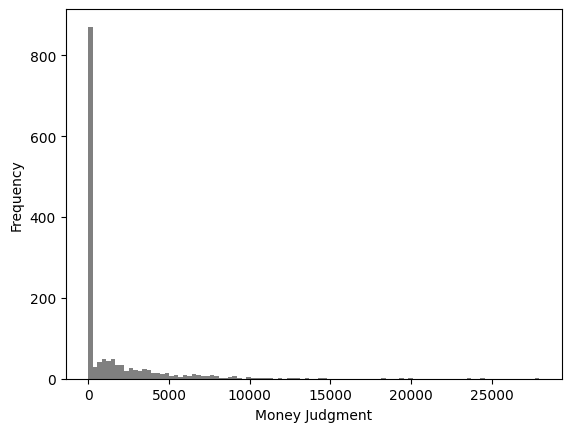

In [37]:
fig, ax = plt.subplots()

# Plot
    # Plot histogram
money_judgment.loc[~money_judgment.isin([42850.80, 49929.28])].plot(kind = "hist",bins = 100, color='grey') # change density to true, because KDE uses density
ax.set_xlabel("Money Judgment")
plt.show()

In [8]:
# Produce treatment timings table.
treatment_timings = (df
                     .groupby(['file_month', 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index='file_month', columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings[
    'Cases Won By Defendant']) / len(df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
# treatment_timings.index = treatment_timings.index.rename("Month of Filing")

# Add column numbers
treatment_timings = figure_utilities.add_column_numbers(treatment_timings)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={('Cases Won By Plaintiff', '(2)'): '{:,.0f}',
                                          ('Cases Won By Defendant', '(1)'): '{:,.0f}',
                                          ('Portion of All Cases', '(3)'): '{:0.2f}'}).to_latex(filename, column_format="lccc",
                                                                                       hrules=True)
treatment_timings

,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
,(1),(2),(3)
All Months,694.0,777.0,1.000000
2019-05,16.0,15.0,0.021074
2019-06,70.0,83.0,0.104011
2019-07,82.0,127.0,0.142080
2019-08,76.0,86.0,0.110129
2019-09,68.0,90.0,0.107410
2019-10,89.0,71.0,0.108770
2019-11,49.0,75.0,0.084296
2019-12,79.0,105.0,0.125085


In [9]:
# Calculate percent of cases which are in high poverty neighborhoods.
df = df.loc[df['judgment_for_plaintiff'] == 1, :]
original_N = len(df)
cases_in_poor_tracts = len(df.loc[df['poor_share2010'] > 0.20, :])
share_cases_in_poor_tracts = round(100 * (cases_in_poor_tracts / original_N), 2)

In [15]:
# Produce table describing crime groups and their frequency
columns = ['Offense Code', 'Description']
# Read offense codes and their descriptions from BPD spreadsheet
offense_codes_and_descriptions = pd.read_excel(INPUT_DATA_OFFENSE_CODES)
offense_codes_and_descriptions.columns = columns
offense_codes_and_descriptions = offense_codes_and_descriptions.set_index('Offense Code')

group_0_crimes = pd.DataFrame([['All', '']], columns=columns)
group_0_crimes = pd.concat([group_0_crimes], axis=0, keys=['All Crimes']).reset_index(level=1, drop=True)
group_0_crimes.index.name = "Incident Group"
group_0_crimes = group_0_crimes.reset_index().set_index(["Incident Group", 'Offense Code'])

crime_group_dfs = [group_0_crimes]
offense_code_groups = [constants.Analysis.larceny,
                       constants.Analysis.drugs,
                       constants.Analysis.vandalism,
                       constants.Analysis.assault,
                       constants.Analysis.auto_theft]
labels = ["Larceny", "Drugs", "Vandalism", "Assault", "Auto Theft"]
for offense_codes, label in zip(offense_code_groups, labels):
    crime_group_df = offense_codes_and_descriptions.loc[offense_codes, :].reset_index().drop_duplicates()
    crime_group_df = pd.concat([crime_group_df], axis=0, keys=[label]).reset_index(level=1, drop=True)
    crime_group_df.index.name = "Incident Group"
    crime_group_df = crime_group_df.reset_index().set_index(["Incident Group", 'Offense Code'])
    crime_group_dfs.append(crime_group_df)
crime_group_df = pd.concat(crime_group_dfs, axis=0)

# Export to LaTeX.
# Clean description column to avoid silent LaTeX errrors
crime_group_df.loc[:, 'Description'] = crime_group_df['Description'].str.replace("&", "\\&", regex=False)
crime_group_df.loc[:, 'Description'] = crime_group_df['Description'].str.replace("$", "\\$", regex=False)

# Split into two pages
crime_group_df_page_1 = crime_group_df.loc[["Auto Theft", "Assault"], :]
crime_group_df_page_2 = crime_group_df.loc[["Drugs"], :]
crime_group_df_page_3 = crime_group_df.loc[["Larceny", "Vandalism"], :]

for df, page_number in zip([crime_group_df_page_1, crime_group_df_page_2, crime_group_df_page_3], [1, 2, 3]):
    drop_for_space_reasons = "RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON)"
    latex = (df
             .loc[df['Description'] != drop_for_space_reasons, :]
             .style
             .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
             .to_latex(None,
                       column_format="lll",
                       hrules=True,
                       clines="skip-last;data"))
    with open(os.path.join(OUTPUT_TABLES, f"crime_groups_page_{page_number}.tex"), 'w') as file:
        file.write(latex)

## Write Statistics to File

In [11]:
with open(OUTPUT_STATISTICS, 'w') as file:
    file.write(f"\n\\def\\shareplaintiffsindividuals{'{' + str(share_plaintiffs_individuals) + ' }'}\n")
    file.write(f"\n\\def\\sharenonentityplaintiffswithattorney{'{' + str(share_non_entity_plaintiffs_with_attorney) + ' }'}\n")
    file.write(f"\n\\def\\sharecasesinpoortracts{'{' + str(share_cases_in_poor_tracts) + ' }'}\n")
    file.write(f"\n\\def\\sample_size{'{' + str(sample_size) + ' }'}\n")
    file.write(f"\n\\def\\sharewithmoneyjudgmentzero{'{' +  f'{share_with_money_judgment_0 :0f}'+ ' }'}\n")
    file.write(f"\n\\def\\sixtiethpercentilevalue{'{' +  f'{round(sixtieth_percentile_value, -1):g}' + ' }'}\n")

In [12]:
f'{round(sixtieth_percentile_value, -1):g}'

'450'